# Finding spurious correlations

Data sources:  
|  | URL | Save location |
| --- | --- | --- |
| Baby Names | https://www.ssa.gov/oact/babynames/names.zip | `/names-by-yob` |
| Meat availability | https://www.ers.usda.gov/webdocs/DataFiles/50472/mtpcc.xlsx?v=6503.7 | `/mtpcc.xlsx` |

In [17]:
from pathlib import Path
from urllib.request import urlopen
from shutil import unpack_archive

NAME_DATA = Path("names-by-yob/")
NAMES_ZIP = Path("names.zip")
names_zip_archive = "https://web.archive.org/web/20230317205251if_/https://www.ssa.gov/oact/babynames/names.zip"
if not NAME_DATA.exists() or not all((NAME_DATA / f"yob{year}").exists() for year in range(1880, 2023)):
    if not Path(NAMES_ZIP).exists():
        with urlopen(names_zip_archive) as names_zip_dl, \
             open(NAMES_ZIP, "wb") as names_zip:
            names_zip.write(names_zip_dl.read())

    NAME_DATA.mkdir(exist_ok=True)
    unpack_archive(NAMES_ZIP, NAME_DATA)

In [1]:
import pandas as pd
import glob

In [2]:
from sys import stderr

def load_names_by_yob() -> list[pd.DataFrame]:
    dfs = []
    for file in glob.glob("names-by-yob/yob*.txt"):
        raw_data = pd.read_csv(file, header=None)
        raw_data.index = pd.Series(zip(raw_data[1], raw_data[0]))
        row_df = raw_data.loc[raw_data[2] > 100].drop(raw_data[[0, 1]], axis=1).T
        row_df.index = [int(file[16:20])]
        dfs.append(row_df)
        print(f"processed {file}", file=stderr, end="\r")
    return pd.concat(dfs)

In [3]:
df = load_names_by_yob()

In [4]:
sorted_df = df.sort_index().reorder_levels([1, 0], axis=1).fillna(0)

In [5]:
sorted_df

,Mary,Anna,Emma,Elizabeth,Minnie,Margaret,Ida,Alice,Bertha,Sarah,...,Klay,Masiah,Rylo,Tymir,Yazan,Brewer,Divine,Jasai,Oaklen,Oden
,F,F,F,F,F,F,F,F,F,F,...,M,M,M,M,M,M,M,M,M,M
1880,7065,2604,2003,1939,1746.0,1578,1472.0,1414,1320.0,1288,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1881,6919,2698,2034,1852,1653.0,1658,1439.0,1308,1324.0,1226,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1882,8148,3143,2303,2186,2004.0,1821,1673.0,1542,1508.0,1410,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1883,8012,3306,2367,2255,2035.0,1881,1634.0,1488,1681.0,1359,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1884,9217,3860,2587,2549,2243.0,2142,1882.0,1732,1789.0,1518,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018,2359,4185,18801,8588,0.0,2332,193.0,3658,0.0,3774,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019,2235,3840,17194,7912,0.0,2212,183.0,3547,0.0,3316,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020,2220,3503,15680,7278,0.0,2192,194.0,3284,0.0,3060,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [7]:
mtpcc = pd.read_excel("mtpcc.xlsx", sheet_name="Boneless", header=[0, 1], skiprows=[0, 3, 4, 5], skipfooter=7)

In [8]:
mtpcc.index = list(mtpcc.iloc[:, 0])
# beef_per_capita = mtpcc[("Red meat", "Beef")]
beef_per_capita = mtpcc[("Red meat", "Beef")] / mtpcc["Total2", "Unnamed: 11_level_1"]

In [9]:
names = sorted_df.columns
nan = float("nan")
corrs = pd.DataFrame(nan, index=range(-30, 33, 3), columns=names)
for j, name in enumerate(names):
    if sorted_df[name].isna().sum() > 50:
        continue
    c = corrs[name][0] = beef_per_capita.corr(sorted_df[name])
    for i in range(-30, 0, 3):
        corrs[name][i] = beef_per_capita.corr(sorted_df[name].shift(i))
    for i in range(0, 33, 3):
        corrs[name][i] = beef_per_capita.corr(sorted_df[name].shift(i))
    print(f"processed {j+1}/{len(names)}", end="\r", file=stderr)
corrs

,Mary,Anna,Emma,Elizabeth,Minnie,Margaret,Ida,Alice,Bertha,Sarah,...,Klay,Masiah,Rylo,Tymir,Yazan,Brewer,Divine,Jasai,Oaklen,Oden
,F,F,F,F,F,F,F,F,F,F,...,M,M,M,M,M,M,M,M,M,M
-30,-0.409433,0.799731,0.555173,-0.116446,-0.215882,-0.330272,-0.373870,-0.326729,-0.327975,0.334735,...,-0.135747,-0.135747,-0.135747,-0.135747,-0.135747,-0.135747,-0.135747,-0.135747,-0.135747,-0.135747
-27,-0.409534,0.845507,0.348744,0.115525,-0.223052,-0.349123,-0.363312,-0.420854,-0.307949,0.531862,...,-0.124650,-0.124650,-0.124650,-0.124650,-0.124650,-0.124650,-0.124650,-0.124650,-0.124650,-0.124650
-24,-0.395827,0.812033,0.104966,0.313843,-0.210194,-0.357054,-0.317890,-0.464543,-0.269226,0.678740,...,-0.125524,-0.125524,-0.125524,-0.125524,-0.125524,-0.125524,-0.125524,-0.125524,-0.125524,-0.125524
-21,-0.362547,0.650905,-0.092245,0.432037,-0.214755,-0.342575,-0.262606,-0.458356,-0.229898,0.763352,...,-0.134433,-0.134433,-0.134433,-0.134433,-0.134433,-0.134433,-0.134433,-0.134433,-0.134433,-0.134433
-18,-0.306926,0.463728,-0.275777,0.558953,-0.178371,-0.295162,-0.194277,-0.422512,-0.168599,0.796008,...,-0.154154,-0.154154,-0.154154,-0.154154,-0.154154,-0.154154,-0.154154,-0.154154,-0.154154,-0.154154
-15,-0.245163,0.274408,-0.434879,0.679772,-0.141304,-0.217322,-0.128067,-0.360509,-0.106165,0.795070,...,-0.150711,-0.150711,-0.150711,-0.150711,-0.150711,-0.150711,-0.150711,-0.150711,-0.150711,-0.150711
-12,-0.164599,0.120894,-0.557147,0.706804,-0.103306,-0.142176,-0.072138,-0.296497,-0.054999,0.726335,...,-0.160273,-0.160273,-0.160273,-0.160273,-0.160273,-0.160273,-0.160273,-0.160273,-0.160273,-0.160273
-9,-0.088749,0.008236,-0.636910,0.683415,-0.060454,-0.086521,-0.031508,-0.241412,-0.010074,0.597907,...,-0.168691,-0.168691,-0.168691,-0.168691,-0.168691,-0.168691,-0.168691,-0.168691,-0.168691,-0.168691
-6,-0.001271,-0.048308,-0.683859,0.684238,-0.019166,-0.021909,0.014504,-0.177314,0.031739,0.457420,...,-0.186285,-0.186285,-0.186285,-0.186285,-0.186285,-0.186285,-0.186285,-0.186285,-0.186285,-0.186285


In [10]:
for i in range(0, 20):
    print(i, beef_per_capita.loc[1930:].corr(sorted_df[("Maggie", "F")].loc[1930:].shift(i)))

0 -0.7663561274081755
1 -0.7917376309529955
2 -0.8173301652861282
3 -0.84163364818715
4 -0.8605976784651242
5 -0.8711460411330287
6 -0.8753240847793744
7 -0.8836358263521249
8 -0.8895465859286175
9 -0.8870104429619233
10 -0.8755597263624942
11 -0.8639652326996536
12 -0.8507861808316347
13 -0.8306332815026948
14 -0.810423104949627
15 -0.7930723307882985
16 -0.7738018704622753
17 -0.740453257253658
18 -0.706265817865512
19 -0.669796915950099


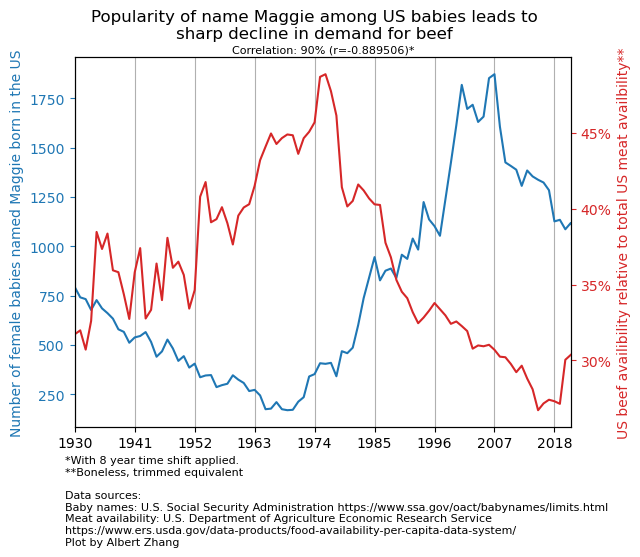

In [18]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

fig, ax1 = plt.subplots()

data = sorted_df[("Maggie", "F")]

color="tab:blue"
data.plot(ax=ax1, color=color)
ax1.set_xlim(1930, 2021)
ax1.set_ylabel("Number of female babies named Maggie born in the US", color=color)
ax1.tick_params(axis="y", labelcolor=color, color=color)
ax1.set_xticks(range(1930, 2020, 11))
ax1.grid(axis="x", which="both")

ax2 = ax1.twinx()

color="tab:red"
beef_per_capita.plot(ax=ax2, color=color)
ax2.set_ylabel("US beef availibility relative to total US meat availbility**", color=color)
ax2.tick_params(axis="y", labelcolor=color, color=color)
ax2.yaxis.set_major_formatter(mtick.PercentFormatter(1.0, decimals=0))

ft = fig.suptitle("Popularity of name Maggie among US babies leads to\nsharp decline in demand for beef")
ax1.set_title("Correlation: 90% (r=-0.889506)*", fontsize=8, pad=3)

data_source_txt = """*With 8 year time shift applied.
**Boneless, trimmed equivalent

Data sources:
Baby names: U.S. Social Security Administration https://www.ssa.gov/oact/babynames/limits.html
Meat availability: U.S. Department of Agriculture Economic Research Service
https://www.ers.usda.gov/data-products/food-availability-per-capita-data-system/
Plot by Albert Zhang"""
extra = fig.text(0.11, 0.05, data_source_txt, verticalalignment="top", fontsize=8)

plt.savefig("maggie-beef.png", bbox_extra_artists=(ft, extra), bbox_inches="tight", dpi=144)
plt.savefig("maggie-beef.pdf", bbox_extra_artists=(ft, extra), bbox_inches="tight", dpi=144)
plt.savefig("maggie-beef.svg", bbox_extra_artists=(ft, extra), bbox_inches="tight", dpi=144)